Group 11 workbook where we perform machine learning on a bankruptcy prediction dataset. Data can be found: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

In [ ]:
#All imports nessecary for the work
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import scipy
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
import time
import warnings

from google.colab import drive
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


The below method for reading in data is only temporary if we in the end move this notebook off of google drive. We will need to simply have pandas read the csv from where it is.

In [ ]:
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/My Drive/Group 11 Assignment/data.csv', index_col=False)
df = df.rename(columns=lambda x: x.strip()) #All columns had whitespace at the start, this removes it
df.head(5)

Mounted at /content/drive


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [ ]:
df.var().sort_values(ascending=False)

Quick Asset Turnover Rate               1.139025e+19
Inventory Turnover Rate (times)         1.054929e+19
Operating Expense Rate                  1.048260e+19
Cash Turnover Rate                      8.635506e+18
Total Asset Growth Rate                 8.396768e+18
                                            ...     
Continuous Net Profit Growth Rate       1.012632e-04
Total Asset Return Growth Rate Ratio    9.281798e-05
Cash Flow to Sales                      8.726074e-05
Working capitcal Turnover Rate          8.027056e-05
Net Income Flag                         0.000000e+00
Length: 96, dtype: float64

In [ ]:
df.drop(['Net Income Flag'], axis=1, inplace=True)

In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.400132,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,0.047578
s

In [ ]:
df.corr()['Bankrupt?'].sort_values(ascending=False)

Bankrupt?                                                  1.000000
Debt ratio %                                               0.250161
Current Liability to Assets                                0.194494
Borrowing dependency                                       0.176543
Current Liability to Current Assets                        0.171306
                                                             ...   
Net worth/Assets                                          -0.250161
ROA(C) before interest and depreciation before interest   -0.260807
ROA(B) before interest and depreciation after tax         -0.273051
ROA(A) before interest and % after tax                    -0.282941
Net Income to Total Assets                                -0.315457
Name: Bankrupt?, Length: 95, dtype: float64

Sorted correlation between the bankrupt status (0 or 1) and the descriptors from the data set. It was found that no single descriptor was highly correlated to bankrupt status of the company. The best correlation found was a negative correlation with the 'Net Income to Total Assests'.

The confusion matrix for the decision stump is:
[[6599    0]
 [ 220    0]]
The best accuracy using a single split is 0.968
This accuracy is acheived by splitting the Total Asset Growth Rate at a value of 0.0003670415171654895
The balanced accuracy is 0.5



[Text(167.4, 163.07999999999998, 'X[29] <= 0.0\ngini = 0.062\nsamples = 6819\nvalue = [6599, 220]'),
 Text(83.7, 54.360000000000014, 'gini = 0.485\nsamples = 189\nvalue = [111, 78]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.042\nsamples = 6630\nvalue = [6488, 142]')]

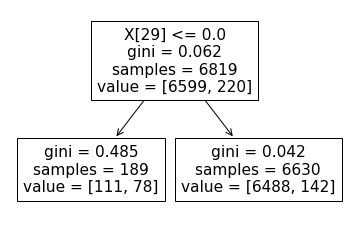

In [ ]:
bankrupt = df['Bankrupt?']
descriptors = df[df.columns[1:]]
decision_stump = DecisionTreeClassifier(max_depth=1)
decision_stump.fit(descriptors, bankrupt)
bankrupt_predict = decision_stump.predict(descriptors)
accuracy = decision_stump.score(descriptors, bankrupt)
feature_idx = decision_stump.tree_.feature[0]
feature_name = df.columns[feature_idx]
threshold = decision_stump.tree_.threshold[0]
balanced_accuracy = balanced_accuracy_score(bankrupt, bankrupt_predict)
confusion_matrix = cm(bankrupt, bankrupt_predict)
print("The confusion matrix for the decision stump is:")
print(confusion_matrix)
print("The best accuracy using a single split is {:.3f}".format(accuracy))
print("This accuracy is acheived by splitting the {} at a value of {}".format(feature_name, threshold))
print("The balanced accuracy is {}".format(balanced_accuracy))
print('')
plot_tree(decision_stump)

The above work shows the best single split found using sklearn's DecisionTreeClassifier when making a decision stump (only one split considered). This shows that if only one feature is chosen, the best  split that can occur is when the 'Total Asset Growth Rate' is split at 0.000367. The split does not allow the bankrupt class (220 samples total), to be larger class in either leaf, meaning both leaves would have a 'Not Bankrupt' class. Overall, the imbalance in the dataset means work needs to be done for more useful machine learning tools to be developed. The high accuracy obtained is due to everything being classified as not bankrupt.

**Data Preprocessing**

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean((a-b)**2))
pd.options.display.max_columns = None
# to make this notebook's output identical at every run
np.random.seed(123)

In [ ]:
# Separating the independent variables from dependent variables

# need new dataframe to get column list for discrete_vars
df2 = df.drop(["Liability-Assets Flag", "Bankrupt?"], axis=1)

discrete_vars = list(df2.columns)
categorical_vars = ["Liability-Assets Flag"]
dependent_vars = ["Bankrupt?"]

In [ ]:
# Categorical - impute, one hot encode
cat_si_step = ('si', SimpleImputer(strategy='constant'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, categorical_vars)]

# Numerical - impute, scale
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, discrete_vars)]

In [ ]:
# apply pipeline to our data
descriptor_names = categorical_vars + discrete_vars
ct = ColumnTransformer(transformers=cat_transformers + num_transformers)
ct.fit(df[descriptor_names])
X = ct.transform(df[descriptor_names])
y = df[['Bankrupt?']].values

In [ ]:
# train test split, random seed set to 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4773, 95) (2046, 95) (4773, 1) (2046, 1)


In [ ]:
# over sampling for imbalanced data
# define oversampling strategy
SMOTE_use = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE_use.fit_resample(X_train, y_train)

print(X_train_SMOTE.shape, X_test.shape, y_train_SMOTE.shape, y_test.shape)

(9226, 95) (2046, 95) (9226,) (2046, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Try to quickly train a RF model using PCA to reduce the dimensionality
# PCA to reduce the dataset's dimensionality, variance ratio of 95%.
pca = PCA(n_components=0.95)
pca_training_X = pca.fit_transform(X_train_SMOTE)
rfc_2 = RandomForestClassifier(random_state=42, n_jobs=-1)
t0 = time.time()
rfc_2.fit(pca_training_X, y_train_SMOTE)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))
pca_X_test = pca.transform(X_test)
y_pred = rfc_2.predict(pca_X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
confusion_matrix = cm(y_test, y_pred)
print("The confusion matrix for the PCA RF is:")
print(confusion_matrix)
print("The PCA RF accuracy is {:.3f}".format(accuracy))
print("The PCA RF balanced accuracy is {}".format(balanced_accuracy))

Training took 2.68s
The confusion matrix for the PCA RF is:
[[1932   54]
 [  41   19]]
The PCA RF accuracy is 0.954
The PCA RF balanced accuracy is 0.6447381671701913


Using PCA in the RF does not seem to give high quality results, this leads us to try and use the full dimensions of the work.

In [ ]:
#Model 1 - Random Forest 
#Train the Random Forest Classifier and measure processing time
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
t0 = time.time()
rfc.fit(X_train_SMOTE, y_train_SMOTE)
t1 = time.time()
print("Training unfit model took {:.2f}s".format(t1 - t0))

#Perform gridsearch for random forest to tune hyperparameters
rfc_grid_search = False #Set to True to perform GridSearchCV for RFC. Set to false as it takes 7+ minutes to perform the code written below
if rfc_grid_search:
    rfc_test = RandomForestClassifier(random_state=42, n_jobs=-1)
    params = {'max_depth': np.arange(2, 8),
              'min_samples_leaf': np.arange(1, 7),
              'min_samples_split': np.arange(1, 7)}
    t0 = time.time()
    rfc_gs = GridSearchCV(rfc_test, params, cv=2, verbose=1, n_jobs=-1) #Only used 2-fold CV due to timing. Could use more if needed.
    rfc_gs.fit(X_train_SMOTE, y_train_SMOTE)
    t1 = time.time()
    print("Grid search training took {:.2f}s".format(t1 - t0))
    rfc_fit = rfc_gs.best_estimator_
    best_rf_params = rfc_gs.best_params_
    print(best_rf_params)
else:
    best_rf_params = {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2} #Parameters came from above fitting
    rfc_fit = RandomForestClassifier(random_state=42, n_jobs=-1)
    rfc_fit.set_params(**best_rf_params)
    t0 = time.time()
    rfc_fit.fit(X_train_SMOTE, y_train_SMOTE)
    t1 = time.time()
    print("Training fit model took {:.2f}s".format(t1 - t0))

Training unfit model took 5.26s
Training fit model took 3.06s


In [ ]:
#Accuracy score for the random forest classifier.
for model, fitting in zip([rfc, rfc_fit], ['unfit', 'fit']):
    y_pred = model.predict(X_test)
    accuracy_score_rf = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    confusion_matrix = cm(y_test, y_pred)
    print(f"Confusion matrix of the {fitting} Random Forest is:")
    print(confusion_matrix)
    print(f"The {fitting} Random Forest has an accuracy score of: {accuracy_score_rf}")
    print(f"The {fitting} Random Forest has a balanced accuracy score of: {balanced_accuracy}")
    print('')

Confusion matrix of the unfit Random Forest is:
[[1925   61]
 [  35   25]]
The unfit Random Forest has an accuracy score of: 0.9530791788856305
The unfit Random Forest has a balanced accuracy score of: 0.69297583081571

Confusion matrix of the fit Random Forest is:
[[1848  138]
 [  20   40]]
The fit Random Forest has an accuracy score of: 0.9227761485826002
The fit Random Forest has a balanced accuracy score of: 0.798590130916415



In [ ]:
#Testing feature importance using the fitted RF model
feature_imp = pd.Series(rfc_fit.feature_importances_).sort_values(ascending=False)
print(feature_imp)
print('')
print("The list of the most important features (idx/name)")
for idx in feature_imp.index[:7]:
  print(idx, descriptor_names[idx])

11    0.083935
20    0.075540
41    0.067712
39    0.054069
86    0.047743
        ...   
34    0.000000
48    0.000000
52    0.000000
59    0.000000
87    0.000000
Length: 95, dtype: float64

The list of the most important features (idx/name)
11 Operating Expense Rate
20 Cash Flow Per Share
41 Contingent liabilities/Net worth
39 Long-term fund suitability ratio (A)
86 Total assets to GNP price
9 Non-industry income and expenditure/revenue
24 Realized Sales Gross Profit Growth Rate


The exact order of the list of important feature may change depending on the random state, which is why it is set to 42. This means the exact order of the top performers is not as important as the top 5 or top 10.

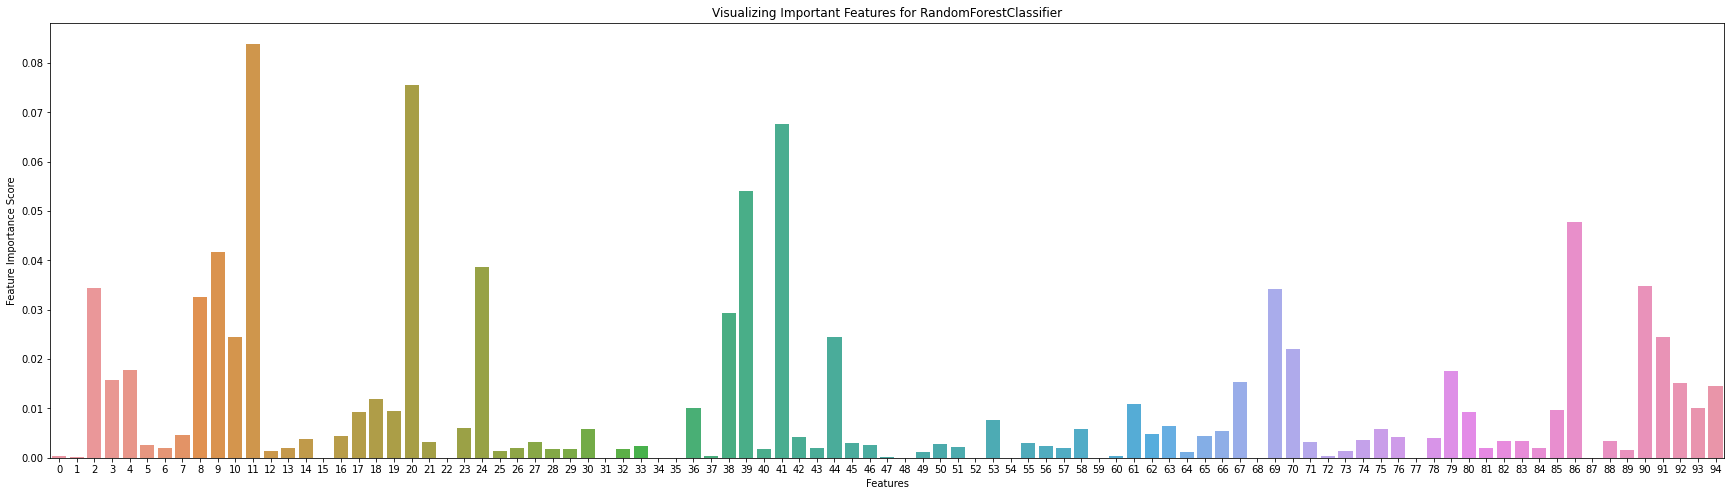

In [ ]:
# Creating a bar plot
sns.barplot(y=feature_imp, x=feature_imp.index)
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(30, 8)

plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.title("Visualizing Important Features for RandomForestClassifier")

plt.show()

In [ ]:
#Create CV training and test scores for various training set sizes for RandomForestClassifier

make_lc = False #Set to True train learning curve. This was done as training took 1+ minutes
if make_lc:
    rfc_fit = RandomForestClassifier()
    rfc_fit.set_params(**best_rf_params)
    train_sizes, train_scores, test_scores = learning_curve(rfc_fit, X_train_SMOTE, y_train_SMOTE,
                                                            #Number of folds in cross-validation
                                                            cv=5, #Reduced as it appeared to take a long time to train
                                                            #Evaluation metric
                                                            scoring='accuracy',
                                                            #Use all computer threads
                                                            n_jobs=-1, 
                                                            #10 different sizes of the training set
                                                            train_sizes=np.linspace(0.01, 1.0, 10))
else:
    #These values came from the above work
    train_sizes = [73, 885, 1697, 2509, 3321, 4132, 4944, 5756, 6568, 7380]
    train_scores = [[1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 0.9966101694915255, 0.9988700564971752, 0.9966101694915255],
                    [1.0, 0.9882144961697112, 0.9923394225103123, 0.9923394225103123, 0.9923394225103123],
                    [1.0, 0.9892387405340773, 0.9888401753686727, 0.9884416102032683, 0.9892387405340773],
                    [1.0, 0.989159891598916, 0.989159891598916, 0.9879554351099067, 0.9903643480879253],
                    [0.9871732817037754, 0.9857212003872217, 0.9869312681510165, 0.9852371732817038, 0.9857212003872217],
                    [0.9724919093851133, 0.9730987055016181, 0.9728964401294499, 0.9726941747572816, 0.9722896440129449],
                    [0.9734190410006949, 0.9723766504517025, 0.9722029186935371, 0.9718554551772064, 0.971681723419041],
                    [0.9750304506699148, 0.9722898903775883, 0.9719853836784409, 0.9732034104750305, 0.972442143727162],
                    [0.9752032520325203, 0.9741192411924119, 0.9730352303523035, 0.974390243902439, 0.9734417344173442]]
    test_scores = [[0.5, 0.5197831978319783, 0.5100271002710027, 0.5414634146341464, 0.5392953929539296],
                   [0.5, 0.5214092140921409, 0.5214092140921409, 0.5224932249322494, 0.5192411924119241],
                   [0.5, 0.6466124661246613, 0.5517615176151761, 0.5528455284552846, 0.5555555555555556],
                   [0.5, 0.6780487804878049, 0.6672086720867209, 0.5615176151761517, 0.5707317073170731],
                   [0.5, 0.7062330623306233, 0.6840108401084011, 0.6655826558265583, 0.6021680216802168],
                   [0.886240520043337, 0.9062330623306233, 0.9040650406504065, 0.9073170731707317, 0.8975609756097561],
                   [0.9312026002166848, 0.9349593495934959, 0.9376693766937669, 0.9463414634146341, 0.9479674796747968],
                   [0.9528710725893824, 0.9490514905149051, 0.9560975609756097, 0.9604336043360434, 0.9658536585365853],
                   [0.9582881906825569, 0.9571815718157182, 0.9550135501355014, 0.9669376693766938, 0.9680216802168021],
                   [0.9604550379198267, 0.9577235772357724, 0.9539295392953929, 0.9653116531165311, 0.9658536585365853]]

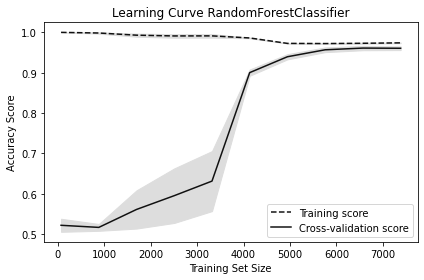

In [ ]:
#Create means and standard deviations of training set scores for RandomForestClassifier
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

#Create means and standard deviations of test set scores for RandomForestClassifier
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

#Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

#Create plot for RandomForestClassifier
plt.title("Learning Curve RandomForestClassifier")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
#Model 2 - GradientBoostingClassifier and measure processing time
#Create the GradientBoostingClassifier

#Fit on training data and measure processing time
gb_clf = GradientBoostingClassifier()
startGB = time.time()
gb_clf.fit(X_train_SMOTE, y_train_SMOTE)
stopGB = time.time()
print("Training time for unfit GradientBoostClassifier is: {:.2f}s".format(stopGB - startGB))

#Use a grid search to tune the hyperparameters
gbc_grid_search = False #Set to True to perform GridSearchCV for GBC. Set to false as it takes 15+ minutes to perform the code written below
if gbc_grid_search:
    gbc_test = GradientBoostingClassifier()
    params = {'max_depth': np.arange(4, 8),   #Using a reduced grid based on the shown above RF results, and time to fit GBC takes longer
              'min_samples_leaf': np.arange(1, 4),
              'min_samples_split': np.arange(1, 4)}
    t0 = time.time()
    gb_gs = GridSearchCV(gbc_test, params, cv=2, verbose=1, n_jobs=-1)
    gb_gs.fit(X_train_SMOTE, y_train_SMOTE)
    t1 = time.time()
    print("Grid search training took {:.2f}s".format(t1 - t0))
    best_gb_params = gb_gs.best_params_
    gbc_fit = gb_gs.best_estimator_
else:
    best_gb_params = {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3} #Parameters came from above fitting
    gbc_fit = GradientBoostingClassifier()
    gbc_fit.set_params(**best_gb_params)
    startGB = time.time()
    gbc_fit.fit(X_train_SMOTE, y_train_SMOTE)
    stopGB = time.time()
print("Training time for fit GradientBoostClassifier is: {:.2f}s".format(stopGB - startGB))

Training time for unfit GradientBoostClassifier is: 30.37s
Training time for fit GradientBoostClassifier is: 63.03s


In [ ]:
#Accuracy prediction of GradientBoostingClassifier on the test_set
for model, fitting in zip([gb_clf, gbc_fit], ['unfit', 'fit']):
    y_pred = model.predict(X_test)
    accuracy_score_gb = accuracy_score(y_test, y_pred)
    balanced_accuracy_gb = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    confusion_matrix = cm(y_test, y_pred)
    print(f"Confusion matrix of the {fitting} Gradient Boosted Classifier is:")
    print(confusion_matrix)
    print(f"The {fitting} Gradient Boosted Classifier has an accuracy score of: {accuracy_score_gb}")
    print(f"The {fitting} Gradient Boosted Classifier has a balanced accuracy score of: {balanced_accuracy_gb}")
    print('')

Confusion matrix of the unfit Gradient Boosted Classifier is:
[[1881  105]
 [  25   35]]
The unfit Gradient Boosted Classifier has an accuracy score of: 0.9364613880742912
The unfit Gradient Boosted Classifier has a balanced accuracy score of: 0.7652316213494461

Confusion matrix of the fit Gradient Boosted Classifier is:
[[1936   50]
 [  32   28]]
The fit Gradient Boosted Classifier has an accuracy score of: 0.9599217986314761
The fit Gradient Boosted Classifier has a balanced accuracy score of: 0.7207452165156092



In [ ]:
#Testing feature importance using the fitted GBC model
feature_imp = pd.Series(gbc_fit.feature_importances_).sort_values(ascending=False)
print(feature_imp)
print('')
print("The list of the most important features (idx/name)")
for idx in feature_imp.index[:7]:
  print(idx, descriptor_names[idx])

11    0.514338
41    0.063811
38    0.059328
90    0.049364
39    0.036040
        ...   
54    0.000000
59    0.000000
77    0.000000
87    0.000000
52    0.000000
Length: 95, dtype: float64

The list of the most important features (idx/name)
11 Operating Expense Rate
41 Contingent liabilities/Net worth
38 Net worth/Assets
90 Liability to Equity
39 Long-term fund suitability ratio (A)
63 Inventory/Current Liability
80 Cash Flow to Total Assets


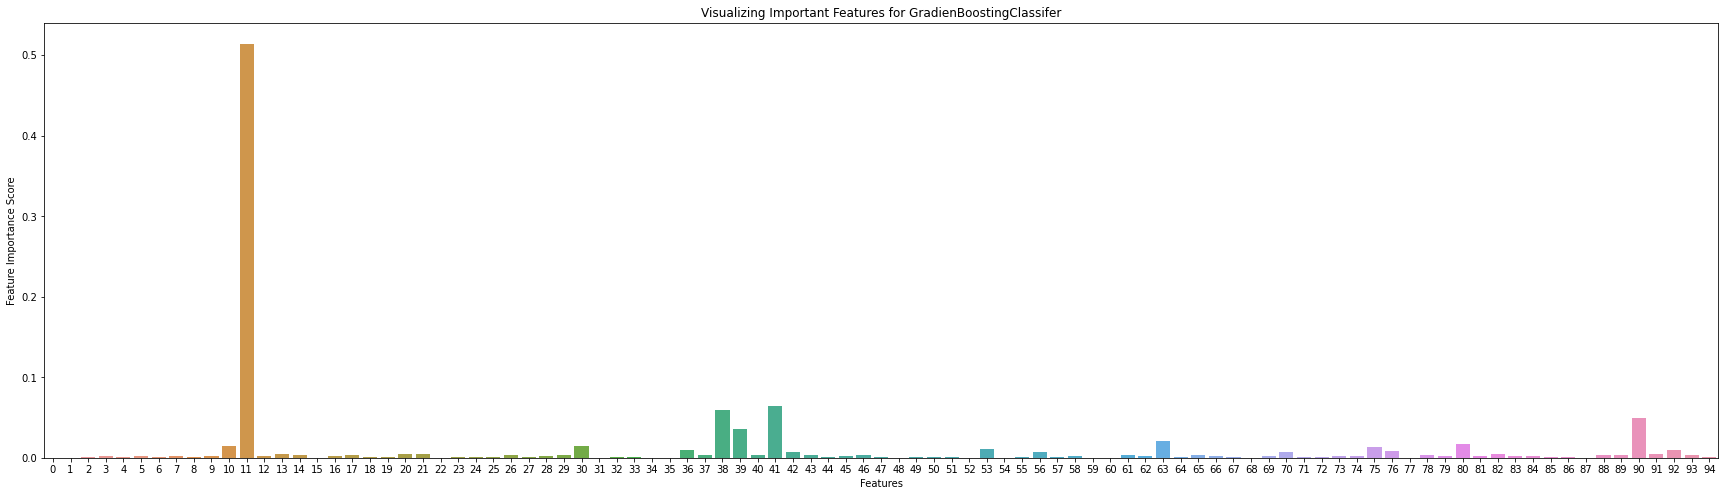

In [ ]:
# Creating a bar plot
sns.barplot(y=feature_imp, x=feature_imp.index)
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(30, 8)

plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.title("Visualizing Important Features for GradienBoostingClassifer")

plt.show()

In [ ]:
#Create CV training and test scores for various training set sizes for GradienBoostingClassifier

make_lc = False #Set to True train learning curve. This was done as training took 14+ minutes
if make_lc:
    gbc_fit = GradientBoostingClassifier()
    gbc_fit.set_params(**best_gb_params)
    train_sizes, train_scores, test_scores = learning_curve(gbc_fit, X_train_SMOTE, y_train_SMOTE,
                                                            #Number of folds in cross-validation
                                                            cv=5, #Reduced as it appeared to take a long time to train
                                                            #Evaluation metric
                                                            scoring='accuracy',
                                                            #Use all computer threads
                                                            n_jobs=-1, 
                                                            #10 different sizes of the training set
                                                            train_sizes=np.linspace(0.01, 1.0, 10))
else:
    #These values came from the above work
    train_sizes =  [ 73, 885, 1697, 2509, 3321, 4132, 4944, 5756, 6568, 7380]
    train_scores =  [[np.nan, 1., 1., 1., 1.],
                     [np.nan, 1., 1., 1., 1.],
                     [np.nan, 1., 1., 1., 1.],
                     [np.nan, 1., 1., 1., 1.],
                     [np.nan, 1., 1., 1., 1.],
                     [ 1., 1., 1., 1., 1.],
                     [ 1., 1., 1., 1., 1.],
                     [ 1., 1., 1., 1., 1.],
                     [ 1., 1., 1., 1., 1.],
                     [ 1., 1., 1., 1., 1.]]
    test_scores =  [[np.nan, 0.5501355, 0.56422764, 0.57831978, 0.57723577],
                    [np.nan, 0.54471545, 0.55392954, 0.55338753, 0.55501355],
                    [np.nan, 0.7197832, 0.5902439, 0.60596206, 0.60108401],
                    [np.nan, 0.74254743, 0.76585366, 0.67533875, 0.67262873],
                    [np.nan, 0.80867209, 0.79728997, 0.79132791, 0.71436314],
                    [0.92524377, 0.95880759, 0.95121951, 0.95934959, 0.95392954],
                    [0.9631636, 0.9799458, 0.97344173, 0.98211382, 0.97723577],
                    [0.97562297, 0.9804878, 0.98265583, 0.98644986, 0.98915989],
                    [0.9772481, 0.98157182, 0.97940379, 0.98644986, 0.98699187],
                    [0.97941495,0.97940379, 0.9804878, 0.98590786, 0.98699187]]

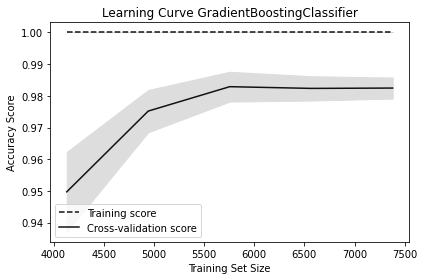

In [ ]:
#Create means and standard deviations of training set scores for GradientBoostingClassifier
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

#Create means and standard deviations of test set scores for GradientBoostingClassifier
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

#Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

#Create plot for GradientBoostingClassifier
plt.title("Learning Curve GradientBoostingClassifier")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()